# What factors are contributing to the high homeless population in New York City?

**An analysis by Nana Kwon and Priya Verma** <br>
**Published on December 15, 2019**

# Table of Contents
1. Introduction
2. Data Munging <br>
    A. NYC homeless population data <br>
    B. NYC homeless shelter data <br>
    C. NYC cost of housing data <br>
3. Data Exploration & Analysis <br>
    A. Analyzing the homeless population in each NYC neighborhood as compared to the number of accessible shelters in each neighborhood <br>
    B. Analyzing the homeless population in each NYC neighborhood as compared to the average cost of housing in each neighborhood <br>
4. Conclusion


# 1. Introduction

New York City has the largest homeless population in the United States. According to the [Department of Housing & Urban Development](https://www.wsj.com/articles/federal-data-show-nearly-80-000-homeless-in-new-york-city-11571922000) nearly 80,000 NYC residents are homeless. It's unclear why NYC has such a high concentration of homelessness. For reference, the second-highest city in terms of homelessness is Los Angeles, which has more residents than NYC, but has roughly 40,000 fewer homeless people (source: [DataLab](https://datalab.usaspending.gov/homelessness-analysis.html))

We hypothesized that the high cost of housing in New York City and the few resources for the homeless (shelters, soup kitchens) contribute to the high concentration of homelessness. To explore these claims, we collected and analyzed data on homeless populations, homeless shelters, and housing costs in each of NYC’s five boroughs: Manhattan, The Bronx, Queens, Brooklyn, and Staten Island.

# 2. Data Munging

**2A. NYC Homeless population data**

To begin, we searched online to find public data on the homeless population of each NYC borough. We found this data published in a table on [CityLimits.org](https://citylimits.org/2019/09/10/data-drop-which-nyc-neighborhoods-host-the-most-homeless-shelter-beds/) on a webpage from September 10, 2019. To obtain this data, we first imported all the relevant packages that will be needed in this project

In [243]:
import bs4
import folium
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

Next, we requested the data from CityLimits.org and used [BeautifulSoup](https://www.pythonforbeginners.com/beautifulsoup/beautifulsoup-4-python) to read the webpage.

In [219]:
response = urlopen("https://citylimits.org/2019/09/10/data-drop-which-nyc-neighborhoods-host-the-most-homeless-shelter-beds/")
soup = BeautifulSoup(response.read())

Now, to just obtain the table from CityLimits.org with the homeless population data, we used BeautifulSoup to access the html 'table' tags. However, since the table that we needed is the second table on the webpage, we requested the table we need by adding the index [1]. Here, you can see these commands executed, with the resulting table printed. 

In [220]:
webpage = soup.findAll('table')[1]
table = pd.read_html(str(webpage), flavor='bs4', header=0)
table = pd.concat(table)

table

,Borough,Individuals sheltered in the borough,Individuals in the shelter system who come from the borough
0,Bronx,31.42%,38.34%
1,Brooklyn,28.36%,28.63%
2,Manhattan,22.00%,16.67%
3,Queens,17.96%,15.33%
4,Staten Island,0.26%,2.37%


This data just tells us the percentage of people in the NYC homeless shelter system who come from each borough. This data is useful, but we recognized that the number of people in shelters is not synonymous with the total number of homeless people. Unfortunately, it is difficult to find data on the specific number of homeless people in NYC because a large percentage of the homeless population is not recognized as homeless by the government (source: [NCBI](https://www.ncbi.nlm.nih.gov/books/NBK218229/)).

Data from the [Department of Homeless Security](https://data.cityofnewyork.us/Social-Services/DHS-Homeless-Shelter-Census/3pjg-ncn9) tells us that roughly 60,000 people are residing in shelters in NYC. Statistics from the [Department of Housing & Urban Development](https://www.wsj.com/articles/federal-data-show-nearly-80-000-homeless-in-new-york-city-11571922000) tell us that about 78,000 people total are homeless in NYC.



To obtain an estimate of the overall homeless population in NYC boroughs, we multiplied the percentages in the table above (from the column 'Individuals in the shelter system who come from the borough') by 78,000. We extended these percentages to not just the sheltered population, but to the total homeless population, because we felt it would be safe to assume that areas with more homeless people would have a higher percentage of people in the shelter system. 

In [221]:
# Here, we stripped the % sign from the data
table['Individuals in the shelter system who come from the borough'] = table['Individuals in the shelter system who come from the borough'].str.replace('%', '')

# Now, we multiplied the percentages by 780 (instead of dividing my percentages by 100 and then multiplying them by 78,000)
table['Total Homeless Population'] = table.apply(lambda row: float(row['Individuals in the shelter system who come from the borough']) * 780.00, axis = 1)

table

,Borough,Individuals sheltered in the borough,Individuals in the shelter system who come from the borough,Total Homeless Population
0,Bronx,31.42%,38.34,29905.2
1,Brooklyn,28.36%,28.63,22331.4
2,Manhattan,22.00%,16.67,13002.6
3,Queens,17.96%,15.33,11957.4
4,Staten Island,0.26%,2.37,1848.6


To make our data cleaner and easier for later use, we decided to set our dataframe's index to be the Borough names. Additionally, we renamed "Bronx" as "The Bronx" for consistency later on.

In [222]:
table.at[0, 'Borough'] = 'The Bronx'
table.set_index('Borough', inplace=True)

table

,Individuals sheltered in the borough,Individuals in the shelter system who come from the borough,Total Homeless Population
Borough,,,
The Bronx,31.42%,38.34,29905.2
Brooklyn,28.36%,28.63,22331.4
Manhattan,22.00%,16.67,13002.6
Queens,17.96%,15.33,11957.4
Staten Island,0.26%,2.37,1848.6


Now, we have obtained a rough estimate of the total homeless population in NYC, by borough. 

**2B. NYC Homeless Shelter Data**

Our next step was to identify the number of homeless shelters in each neighborhood of NYC. We were unable to find a clear data table or csv file published online with this information. However, the [Homeless Shelter Directory](https://www.homelessshelterdirectory.org/) has webpages for each neighborhood of New York, with a list of the shelters within and near the area. 

Our first step was to request the data from their [Manhattan](https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=manhattan&state=NY) webpage.

In [223]:
response = urlopen("https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=Manhattan&state=NY")
soup = BeautifulSoup(response.read())

Next, we created an empty dataframe with a column for the shelter names and a column for their distance from the city center (which is provided on the webpage).

In [224]:
df_man = pd.DataFrame(columns=['Shelter Name', "Distance from city center"])

Then we extracted each of the shelter names listed on the webpage. We were able to locate the names because they were each listed under 'h4' heading tags. Below, you can see a printout of the first ten rows of the dataframe.

In [225]:
shelter_names = []

# Extracting the name of each shelter in Manhattan
for i in soup.findAll('h4'):
    shelter_names.append(i.text)
df_man['Shelter Name'] = shelter_names

# We had to drop these last few rows from the dataframe because they were not the names of shelters, they were links to other webpages
df_man.drop(df_man.loc[109:126].index, inplace=True)

# Additionally, after observing the resulting data, we had to drop the 10th row from the dataframe because the data was not being copied over correctly
df_man.drop(df_man.index[9], inplace=True)

df_man.head(10)

,Shelter Name,Distance from city center
0,Breaking Ground,NaN
1,Covenant House Crisis Shelter NYC,NaN
2,Sylvia's Place,NaN
3,Grand Central Neighborhood Social Services Cor...,NaN
4,Olivieri Drop-In Center,NaN
5,Antonio Olivieri Drop-In Center,NaN
6,Mainchance Drop-In Center,NaN
7,Holy Apostles Soup Kitchen,NaN
8,Bellevue Men’s Shelter NY - HRA Men's Shelter,NaN
10,Church of the Blessed Sacrament Transitional R...,NaN


Next, we extracted each shelter's distance from the city center of Manhattan, which is listed on the webpage two lines below the shelter's name. To isolate the distance, we used the [find_next_sibling\(\)](https://kite.com/python/docs/bs4._s.find_next_sibling) command. Below, you can see the steps we took to do this.

In [226]:
distance = []
for i in soup.find_all('h4'): # Gets the shelter name
    temp = i.find_next_sibling() # Gets the shelter's city and zip code
    if type(temp) != type(None):
        dist = temp.find_next_sibling() # Gets the shelter's distance from the city-center
        if type(dist) != type(None):
            distance.append(dist)

# Here, we clean up the distance data so that we just extract the integers, not any text that also appears.
vals = re.findall(r'\d+\.\d+', str(distance)) 

df_man['Distance from city center'] = vals

df_man

,Shelter Name,Distance from city center
0,Breaking Ground,0.52
1,Covenant House Crisis Shelter NYC,0.61
2,Sylvia's Place,0.64
3,Grand Central Neighborhood Social Services Cor...,0.67
4,Olivieri Drop-In Center,0.74
5,Antonio Olivieri Drop-In Center,0.74
6,Mainchance Drop-In Center,0.90
7,Holy Apostles Soup Kitchen,0.94
8,Bellevue Men’s Shelter NY - HRA Men's Shelter,1.33
10,Church of the Blessed Sacrament Transitional R...,1.34


We are only going to consider the shelters within a 5 mile radius of the city center, because the Homeless Shelter Directory include shelters that are as far as 25 miles away from the heart of Manhattan, and we only want to consider shelters that are accessible to people living within the city. Additionally, it's important to note that homeless people in Manhattan, or in any city, likely have limited transportation options. Therefore, they would likely avoid homeless shelters that are far from the city center.

Thus, we are removing shelters from our dataframe with distances over 5 miles.

In [227]:
for idx, row in df_man.iterrows():
    if float(row['Distance from city center']) > 5.00:
        df_man.drop(idx, inplace=True)

df_man

,Shelter Name,Distance from city center
0,Breaking Ground,0.52
1,Covenant House Crisis Shelter NYC,0.61
2,Sylvia's Place,0.64
3,Grand Central Neighborhood Social Services Cor...,0.67
4,Olivieri Drop-In Center,0.74
5,Antonio Olivieri Drop-In Center,0.74
6,Mainchance Drop-In Center,0.90
7,Holy Apostles Soup Kitchen,0.94
8,Bellevue Men’s Shelter NY - HRA Men's Shelter,1.33
10,Church of the Blessed Sacrament Transitional R...,1.34


Now, we have a list of the 36 shelters that are within a 5 mile radius of the center of Manhattan.

We'll repeat this process for [The Bronx](https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=Bronx&state=NY).

In [228]:
response = urlopen("https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=Bronx&state=NY")
soup = BeautifulSoup(response.read())

df_brx = pd.DataFrame(columns=['Shelter Name', "Distance from city center"])

shelter_names = []

# Extracting the name of each shelter in The Bronx
for i in soup.findAll('h4'):
    shelter_names.append(i.text)
df_brx['Shelter Name'] = shelter_names

# Drops these last few rows because they are not shelters
df_brx.drop(df_brx.loc[109:126].index, inplace=True)

# Extracting each of The Bronx's shelters' distance from the city center

distance = []
for i in soup.find_all('h4'):
    temp = i.find_next_sibling()
    if type(temp) != type(None):
        dist = temp.find_next_sibling()
        if type(dist) != type(None):
            distance.append(dist)

df_brx['Distance from city center'] = distance

# We are only considering shelters within 5 miles of the city center. Therefore, we drop rows 6-108.
df_brx.drop(df_brx.loc[5:108].index, inplace=True)

df_brx

,Shelter Name,Distance from city center
0,The Living Room Drop In Center Bronx,[]
1,Maya's Place,[]
2,Franklin Women's Intake Shelter Bronx NY,[]
3,Cromwell Ave Safe Haven Bronx NY,[]
4,Charles Gay center,[4.85 miles from city center Bronx]


In the table above, we see the 5 shelters that are within 5.0 miles of The Bronx's city center.

When extracting our data, we noticed that the first few shelters listed on the webpage did not have a mileage from the city center available. However, we knew that this webpage lists shelters from closest to farthest distance from the city center. We determined that these shelters did not have listed distances simply because they are already within the city center. Thus, they are 0.00 miles from The Bronx's city center. Therefore, we included these data points in our dataframe.

Now, we can replace the empty distances with 0.00, to reflect that they are within The Bronx's city center. Additionally, we can clean up our data to just contain integers.

In [229]:
regexp = re.compile(r'\d+\.\d+(\s+\w+)+')

for index, row in df_brx.iterrows():
    if str(row['Distance from city center']) == '<br/>':
        row['Distance from city center'] = 0.00
    if regexp.search(str(row['Distance from city center'])):
        row['Distance from city center'] = str(row['Distance from city center'])[3:7]

df_brx

,Shelter Name,Distance from city center
0,The Living Room Drop In Center Bronx,0
1,Maya's Place,0
2,Franklin Women's Intake Shelter Bronx NY,0
3,Cromwell Ave Safe Haven Bronx NY,0
4,Charles Gay center,4.85


Now we repeat the process with data from [Queens](https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=Queens&state=NY).

In [230]:
response = urlopen("https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=Queens&state=NY")
soup = BeautifulSoup(response.read())

df_que = pd.DataFrame(columns=['Shelter Name', "Distance from city center"])

shelter_names = []

# Extracting the name of each shelter in Queens
for i in soup.findAll('h4'):
    shelter_names.append(i.text)
df_que['Shelter Name'] = shelter_names

# Drop these last few rows because they are not shelters
df_que.drop(df_que.loc[111:122].index, inplace=True)

# Extracting each of Queens' shelters' distance from the city center
distance = []
for i in soup.find_all('h4'):
    temp = i.find_next_sibling()
    if type(temp) != type(None):
        dist = temp.find_next_sibling()
        distance.append(dist)

df_que['Distance from city center'] = distance

# We are only considering shelters within 5 miles of the city center, so we can look at the data frame and
# remove shelters that are too far
df_que.drop(df_que.loc[2:110].index, inplace=True)

# Extract just the integers from each distance
regexp = re.compile(r'\d+\.\d+(\s+\w+)+')
for index, row in df_que.iterrows():
    if regexp.search(str(row['Distance from city center'])):
        row['Distance from city center'] = str(row['Distance from city center'])[3:7]

df_que

,Shelter Name,Distance from city center
0,Restfull Nights Organization Inc.,2.68
1,Van Siclen Women's Shelter (Samartan Village),4.96


Now we repeat with data from [Brooklyn](https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=Brooklyn&state=NY).

In [231]:
response = urlopen("https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=Brooklyn&state=NY")
soup = BeautifulSoup(response.read())

df_brk = pd.DataFrame(columns=['Shelter Name', "Distance from city center"])

shelter_names = []

# Extracting the name of each shelter in Brooklyn
for i in soup.findAll('h4'):
    shelter_names.append(i.text)
df_brk['Shelter Name'] = shelter_names

# Drop these last few rows because they are not shelters
df_brk.drop(df_brk.loc[109:127].index, inplace=True)

# Extracting each of Brooklyn's shelters' distance from the city center
distance = []
for i in soup.find_all('h4'):
    temp = i.find_next_sibling()
    if type(temp) != type(None):
        dist = temp.find_next_sibling()
        distance.append(dist)

# Add distances to the dataframe
for index, row in df_brk.iterrows():
    row['Distance from city center'] = distance[index]

# Drop these rows because they are greater than 5 miles from the city center
df_brk.drop(df_brk.loc[35:108].index, inplace=True)

# Extract just the integers from each distance, and replace empty brackets with 0 miles
regexp = re.compile(r'\d+\.\d+(\s+\w+)+')
for index, row in df_brk.iterrows():
    if str(row['Distance from city center']) == '<br/>':
        row['Distance from city center'] = 0.00
    if regexp.search(str(row['Distance from city center'])):
        row['Distance from city center'] = str(row['Distance from city center'])[3:7]
    
df_brk

,Shelter Name,Distance from city center
0,Tillary Street Women's Shelter,0
1,Opportunity House Men's Shelter,0
2,Auburn Family Residence Fort Greene,0
3,URI NYC - Urban Resource Institute,1.39
4,Bowery Mission,1.56
5,New York City Rescue Mission - NYCRM,1.60
6,3rd Street Men's Shelter,1.98
7,Shelter and Food for the Homeless Inc.,2.01
8,One Step Forward Shelter Place,2.06
9,Gates Avenue Center for Opportunity,0


Finally, we repeat the process with data from [Staten Island](https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=Staten%20Island&state=NY).

In [232]:
response = urlopen("https://www.homelessshelterdirectory.org/cgi-bin/id/city.cgi?city=Staten%20Island&state=NY")
soup = BeautifulSoup(response.read())

df_sta = pd.DataFrame(columns=['Shelter Name', "Distance from city center"])

shelter_names = []

# Extracting the name of each shelter in Staten Island
for i in soup.findAll('h4'):
    shelter_names.append(i.text)
df_sta['Shelter Name'] = shelter_names

# Drop these last few rows because they are not shelters
df_sta.drop(df_sta.loc[110:127].index, inplace=True)

# Extracting each of Staten Island's shelters' distance from the city center
distance = []
for i in soup.find_all('h4'):
    temp = i.find_next_sibling()
    if type(temp) != type(None):
        dist = temp.find_next_sibling()
        distance.append(dist)

# Add distances to the dataframe
for index, row in df_sta.iterrows():
    row['Distance from city center'] = distance[index]
    
# Drop these rows because they are greater than 5 miles from the city center
df_sta.drop(df_sta.loc[1:109].index, inplace=True)

# Extract just the integers from each distance, and replace empty brackets with 0 miles
regexp = re.compile(r'\d+\.\d+(\s+\w+)+')
for index, row in df_sta.iterrows():
    if str(row['Distance from city center']) == '<br/>':
        row['Distance from city center'] = 0.00
    if regexp.search(str(row['Distance from city center'])):
        row['Distance from city center'] = str(row['Distance from city center'])[3:7]

df_sta

,Shelter Name,Distance from city center
0,Project Hospitality,0


Now that we collected data on the number of homeless shelters and amenities within and nearby each NYC borough, we decided to create a new dataframe to sum up this data.

In [233]:
# First we created the dataframe
df_shelters = pd.DataFrame({"Borough":['Manhattan', 'The Bronx', 'Queens', 'Brooklyn', 'Staten Island']})

# We set the index of the dataframe to be the borough names, to make it easy to access their values later on.
df_shelters.set_index("Borough", inplace=True)

# Then we populated the number of shelters by taking the length (number of shelters) of each of our previous dataframes
df_shelters.at['Manhattan', 'Number of shelters'] = len(df_man)
df_shelters.at['The Bronx', 'Number of shelters'] = len(df_brx)
df_shelters.at['Queens', 'Number of shelters'] = len(df_que)
df_shelters.at['Brooklyn', 'Number of shelters'] = len(df_brk)
df_shelters.at['Staten Island', 'Number of shelters'] = len(df_sta)

df_shelters

,Number of shelters
Borough,
Manhattan,35.0
The Bronx,5.0
Queens,2.0
Brooklyn,35.0
Staten Island,1.0


**2C. NYC Cost of Housing Data**

Our last step was to calculate the income and cost of housing in each NYC borough. We used a csv file from the [U.S. Census Bureau](https://www.census.gov/quickfacts/fact/table/newyorkcountymanhattanboroughnewyork,bronxcountybronxboroughnewyork,queenscountyqueensboroughnewyork,kingscountybrooklynboroughnewyork,richmondcountystatenislandboroughnewyork,newyorkcitynewyork/HSG010218) that contained many statistics for each borough over the years 2013-2018.<br>

First, we read in the csv file.

In [234]:
df_cost = pd.read_csv('ny_facts.csv')
df_cost.head()

,Fact,Fact Note,"New York County (Manhattan Borough), New York","Value Note for New York County (Manhattan Borough), New York","Bronx County (Bronx Borough), New York","Value Note for Bronx County (Bronx Borough), New York","Queens County (Queens Borough), New York","Value Note for Queens County (Queens Borough), New York","Kings County (Brooklyn Borough), New York","Value Note for Kings County (Brooklyn Borough), New York","Richmond County (Staten Island Borough), New York","Value Note for Richmond County (Staten Island Borough), New York","New York city, New York","Value Note for New York city, New York"
0,"Population estimates, July 1, 2018, (V2018)",NaN,"1,628,701",NaN,"1,432,132",NaN,"2,278,906",NaN,"2,582,830",NaN,"476,179",NaN,"8,398,748",NaN
1,"Population estimates base, April 1, 2010, (V2...",NaN,"1,586,360",NaN,"1,384,603",NaN,"2,230,578",NaN,"2,504,717",NaN,"468,730",NaN,"8,174,988",NaN
2,"Population, percent change - April 1, 2010 (es...",NaN,2.7%,NaN,3.4%,NaN,2.2%,NaN,3.1%,NaN,1.6%,NaN,2.7%,NaN
3,"Population, Census, April 1, 2010",NaN,"1,585,873",NaN,"1,385,108",NaN,"2,230,722",NaN,"2,504,700",NaN,"468,730",NaN,"8,175,133",NaN
4,"Persons under 5 years, percent",NaN,4.7%,NaN,7.2%,NaN,6.2%,NaN,7.2%,NaN,5.8%,NaN,6.5%,NaN


There are many different topics in the dataframe that are not relevant to our analysis, so we are dropping some columns and rows to tidy the dataframe. 

We also rename columns to shorten them and make them easily accessible. Additionally we transpose the dataframe so the data is logically set up. Then, we remove the percentage and dollar signs to convert the strings to numbers so we can apply math operations.

In [235]:
# Drop the unnecessary columns and rows not needed in our analysis
# We want to obtain the data relevant to income and housing costs
cols = [1,3,5,7,9,11,12,13]
df_cost.drop(df_cost.columns[cols], axis=1, inplace=True)
df_cost.drop(df_cost.loc[:18].index, inplace=True)
df_cost.drop(df_cost.loc[20:20].index, inplace=True)
df_cost.drop(df_cost.loc[24:43].index, inplace=True)
df_cost.drop(df_cost.loc[45:].index, inplace=True)

# Shorten the column and row names for easier access
df_cost.columns = ['Fact', 'Manhattan', 'The Bronx', 'Queens', 'Brooklyn', 'Staten Island']
df_cost.drop(['Fact'], axis=1, inplace=True)

# Transpose the dataframe so rows and columns switch 
df_cost = df_cost.T

# Rename new columns
df_cost.columns = ['homeowner_percent', 'mortgage_costs', 'without_mortgage_costs', 'gross_rent', 'income']

# Strip unnecessary characters to get numbers
df_cost['homeowner_percent'] = df_cost['homeowner_percent'].str.rstrip('%').astype('float') / 100.
df_cost.replace(regex=r'\$', value='', inplace=True)
df_cost.replace(regex=r',', value='', inplace=True)

# Convert the datatype of the number strings to floats and ints
df_cost = df_cost.apply(pd.to_numeric)

df_cost

,homeowner_percent,mortgage_costs,without_mortgage_costs,gross_rent,income
Manhattan,0.241,3112,946,1615,79781
The Bronx,0.197,2370,734,1133,36593
Queens,0.445,2482,824,1456,62008
Brooklyn,0.300,2723,843,1314,52782
Staten Island,0.695,2433,856,1229,76244


# 3. Data Exploration & Analysis

**3A.  Analyzing the homeless population in each NYC neighborhood as compared to the number of accessible shelters in each neighborhood**

Now we will use our data from parts 2A and 2B to observe each neighborhood's homeless population and number of accessible shelters. Here, we are defining "accessible shelters" to be shelters within 5 miles of the neighborhood's city center, as described in part 2B. 

To aid in our data visualization, we will use the [folium](https://python-visualization.github.io/folium/) package to generate a map of NYC. We will use circles on each borough to visually represent the number of homeless shelters in each neighborhood.

First, we created a dictionary of our datapoints and used this data to populate a dataframe.

In [236]:
# Renamed this column to make data manipulation cleaner
table.rename(columns={"Individuals in the shelter system who come from the borough": "Percentage"}, inplace=True)

mapData = {
    'Borough' : ['Manhattan', 'The Bronx', 'Queens', 'Brooklyn', 'Staten Island'],
    'Latitude' : [40.780881, 40.755931, 40.7127142, 40.647116, 40.6110382],
    'Longitude' : [-73.9595061, -73.984606, -73.8271103, -73.9380695, -74.0849709],
    'Shelters' : [df_shelters.at['Manhattan', 'Number of shelters'], df_shelters.at['The Bronx', 'Number of shelters'], df_shelters.at['Queens', 'Number of shelters'], df_shelters.at['Brooklyn', 'Number of shelters'], df_shelters.at['Staten Island', 'Number of shelters']], 
    'Total Homeless Population' : [table.at['Manhattan', 'Percentage'], table.at['The Bronx', 'Percentage'], table.at['Queens', 'Percentage'], table.at['Brooklyn', 'Percentage'], table.at['Staten Island', 'Percentage']]
}

df_map = pd.DataFrame(mapData)

df_map

,Borough,Latitude,Longitude,Shelters,Total Homeless Population
0,Manhattan,40.780881,-73.959506,35.0,16.67
1,The Bronx,40.755931,-73.984606,5.0,38.34
2,Queens,40.712714,-73.827110,2.0,15.33
3,Brooklyn,40.647116,-73.938069,35.0,28.63
4,Staten Island,40.611038,-74.084971,1.0,2.37


Then we used this dataframe to create circular markers on a map of NYC.

In [237]:
map_osm = folium.Map(location=[40.75, -73.98], zoom_start=11)

for i in range(0, len(df_map)):
    folium.Circle(
        location=[df_map.iloc[i]['Latitude'], df_map.iloc[i]['Longitude']],
        popup=df_map.iloc[i]['Borough'],
        radius=df_map.iloc[i]['Shelters']*200,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(map_osm)
    

map_osm

As emphasized in the plot above, Manhattan and Brooklyn have a much larger number of homeless shelters near their city centers as compared to The Bronx, Queens, and Staten Island. 

Next, we compared the percentage of shelters in each borough to the percentage of NYC's total homeless population in each borough. To do this, we calculated the percentage of all the shelters within city centers that are located in each borough.

In [238]:
total_shelters = 0.0
for index, row in df_map.iterrows():
    total_shelters = total_shelters + row['Shelters']
    
for index, row in df_map.iterrows():
    df_map['Shelter Percentage'] = df_map['Shelters']/total_shelters

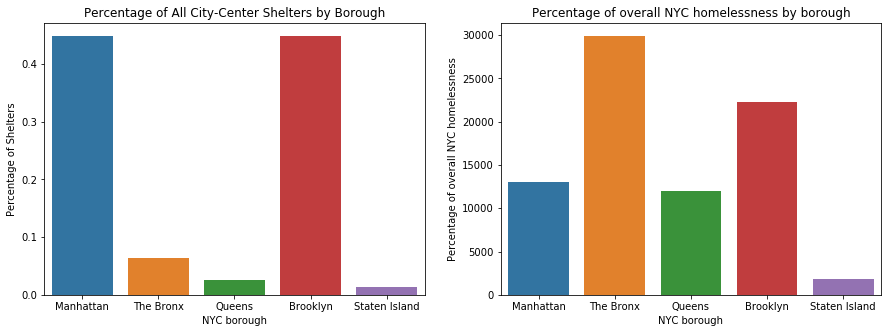

In [239]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Create a barplot of the percentage of all the city-center shelters in each borough
pltA = sns.barplot(x=df_map['Borough'], y=df_map['Shelter Percentage'], data=df_map, ax=ax[0])
# Label the axes and title
pltA.set(xlabel='NYC borough', ylabel='Percentage of Shelters', title='Percentage of All City-Center Shelters by Borough')

# Create a barplot of the percentage of homeless people in the shelter system by borough
sns.barplot(x=table.index, y='Total Homeless Population', data=table, order=["Manhattan", "The Bronx", "Queens", "Brooklyn", "Staten Island"], ax=ax[1])
# Label the axes and title
plt.xlabel('NYC borough')
plt.ylabel('Percentage of overall NYC homelessness')
plt.title('Percentage of overall NYC homelessness by borough')
plt.show()

By observing the two tables above, we noticed that Manhattan and Brooklyn have the largest percentage of all NYC city-center homeless centers, and they also have relatively lower percentages of the NYC homeless population. Meanwhile, The Bronx has the highest proportion of the NYC homeless population, and it has very few of the total city-center shelters. 

**3B.  Analyzing the homeless population in each NYC neighborhood as compared to the average cost of housing in each neighborhood**

The data that we cleaned in our df_cost dataframe are median calculations from the years 2013-2017. For our analysis, we wanted to compare the median income and median housing costs for each borough. In order to do this, we needed to calculate the overall housing cost. 

The data we retrieved in df_cost included the monthly median costs for (1) homeowners with a mortgage, (2) homeowners without a mortgage, and (3) the gross rent for renters. There is a significant difference between the monthly median costs for homeowners with a mortgage and homeowners without a mortgage. To compensate for this difference, we took a [weighted mean](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean).

To determine how each housing cost should be weighed in our average, we referenced [Move.org](https://www.move.org/states-most-mortgage-free-homeowners/) to determine the percentage of homeowners that had mortages and the percentage who were mortgage-free in New York. Unfortunately, we could not find a percentage per borough, so our costs are a generalized estimate. For the weighted mean of homeowner costs, we multiplied the median monthly mortgage costs by 60.93% which is how many New Yorkers have a mortgage plus the median monthly costs without a mortgage multiplied by 39.07% which is how many New Yorkers are mortgage-free. 
<br><br>

<center><i>weighted average of monthly median homeowner costs = (0.6093 * mortage_costs) + (0.3907 * without_mortgage_costs)</i></center>

This data is entered into a new column called 'home_costs'.

<br>
Now, to calculate a weighted average median housing cost between homeowners and renters, we took a weighted mean of the median costs using the homeowner percentages in our dataframe (the owner-occupied housing unit rate). We made a new column called 'renter_percent' to determine how many people are renters. We multiplied the percentage of people that own and live in their houses by the average monthly median costs of homeowners (which we calculated before). We added this product to the percentage of renters multiplied by the median gross rent. 
<br><br>
<center><i>weighted average of monthly median housing cost = (homeowner_percent * home_costs) + (renter_percent * gross_rent)</i></center>
<br>
Finally, we multiplied the mean monthly housing costs by 12 to calculate the yearly costs.

In [240]:
# Calculate the weighted mean of housing costs for homeowners
df_cost['home_costs'] = df_cost['mortgage_costs'].multiply(.6093) + df_cost['without_mortgage_costs'].multiply(.3907)

# Calculate the percentage of people that are renters
df_cost['renter_percent'] = 1 - df_cost['homeowner_percent']

# Calculate the weighted mean of yearly housing costs between homeowners and renters
df_cost['yearly_home_costs'] = (df_cost['home_costs'] * df_cost['homeowner_percent'] + df_cost['gross_rent'] * df_cost['renter_percent']).multiply(12)

df_cost

,homeowner_percent,mortgage_costs,without_mortgage_costs,gross_rent,income,home_costs,renter_percent,yearly_home_costs
Manhattan,0.241,3112,946,1615,79781,2265.7438,0.759,21261.951070
The Bronx,0.197,2370,734,1133,36593,1730.8148,0.803,15009.234187
Queens,0.445,2482,824,1456,62008,1834.2194,0.555,19491.691596
Brooklyn,0.300,2723,843,1314,52782,1988.4840,0.700,18196.142400
Staten Island,0.695,2433,856,1229,76244,1816.8661,0.305,19650.803274


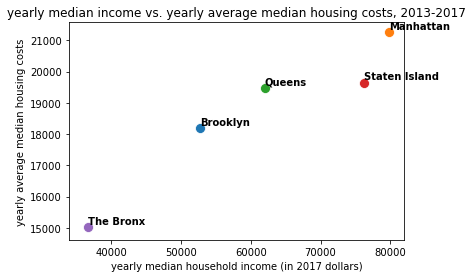

In [241]:
# Create a scatterplot between the income and housing costs
for key, grp in df_cost.groupby(df_cost.index):
    sc = sns.scatterplot(grp['income'], grp['yearly_home_costs'], s=100)

# Label each point
for line in range(0,df_cost.shape[0]):
    sc.text(df_cost.income[line]+0.2, df_cost.yearly_home_costs[line]+100, df_cost.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

# Label the axes and title
plt.xlabel('yearly median household income (in 2017 dollars)')
plt.ylabel('yearly average median housing costs')
plt.title('yearly median income vs. yearly average median housing costs, 2013-2017')

plt.show()

The graph above depicts each borough's yearly median income versus its yearly average median housing cost. This data verifies that areas with high household incomes also have high housing costs.

After making and viewing this graph, we realized that it is important to consider what percentage of peoples' income is going towards their housing costs. For instance, a wealthy person in Manhattan may be paying a considerable amount in housing costs, but this may only be a small percentage of their takehome pay. Meanwhile, a resident of The Bronx may be paying less in housing costs, but this amount could be a large portion of their monthly income.

We created a second plot to take these proportions into consideration. We also created a plot of the percentage of the total NYC homeless population in each borough, for reference (using the data from our 'table' dataframe in 2A).

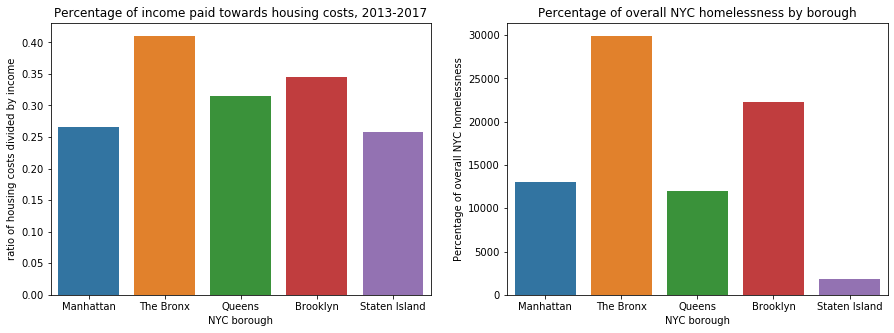

In [242]:
df_cost['ratio'] = df_cost['yearly_home_costs'] / df_cost['income']

fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Create a barplot of the percentage of income that goes towards housing costs
plt1 = sns.barplot(x=df_cost.index, y='ratio', data=df_cost, ax=ax[0])
# Label the axes and title
plt1.set(xlabel='NYC borough', ylabel='ratio of housing costs divided by income', title='Percentage of income paid towards housing costs, 2013-2017')

# Create a barplot of the percentage of homeless people in the shelter system by borough
sns.barplot(x=table.index, y='Total Homeless Population', data=table, order=["Manhattan", "The Bronx", "Queens", "Brooklyn", "Staten Island"], ax=ax[1])
# Label the axes and title
plt.xlabel('NYC borough')
plt.ylabel('Percentage of overall NYC homelessness')
plt.title('Percentage of overall NYC homelessness by borough')
plt.show()

This new plot shows that people residing in The Bronx are contributing about 40% of their yearly income towards housing. Meanwhile, people in Manhattan and Staten Island contribute considerably less of their income (about 25%) to housing. This gives us a better insight into the impact of high housing costs in each neighborhood.

Comparing the two plots above, we can see a strong correlation between the income-to-housing ratio and the percentage of homelessness by borough. The Bronx has the highest proportion of yearly income contributed to housing costs, and it also houses the highest percentage of the overall NYC homeless population. 

# 4. Conclusion

Initially, we believed that NYC neighborhoods with higher housing costs would have a higher concentration of homelessness. After scraping and analyzing our data, we have found this to be false. In fact, we found that boroughs with lower housing costs have much higher concentrations of homelessness.

We needed to account for the income bracket of each borough. After taking this into consideration, we realized that areas with low housing costs have relatively low income brackets, while areas with high housing costs have much, much higher income brackets. Therefore, people in areas like Manhattan are not as burdened by the cost of housing as compared to people in The Bronx, who spend almost half of their income just on their home payments. 

Considering this important factor, it is clear why homelessness is most concentrated in The Bronx. People living in this area have (on average) a low yearly income, and many of them likely have trouble paying their relatively high housing payments. These individuals may become forced to prioritize other expenses (food, family, etc.) over their housing, which may drive them into homelessness.

Our data shows that The Bronx only has 5 homeless shelters within a 5 mile radius of the city center. Clearly, this neighborhood is especially in need of more resources for the homeless, as it contains about 38% of NYC's total homeless population. 

Rising housing costs will continue to raise the number of homeless people in The Bronx (source: [Point2Homes](https://www.point2homes.com/news/canada-real-estate/18-north-american-cities-home-price-staggering-jumps.html)). Establishing more shelters in the area is not a solution, but it may be beneficial.